<a href="https://colab.research.google.com/github/CalculatedContent/xgboost2ww/blob/main/notebooks/PoorlyTrainedCreditModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PoorlyTrained Credit Model
This notebook demonstrates what a **poorlu trained XGBoost model** looks like using WeightWatcher diagnostics.

In this example:

- Training accuracy is high  
- Test accuracy is much lower  
- The spectral fit produces a **large α (alpha)**  
- The model appears structurally unstable  

---

## What this shows

Even when a model looks “strong” on training data, it can:

- Overfit the training set  
- Learn brittle correlations  
- Generalize poorly  

Using **xgboost2ww (WeightWatcher diagnostics for XGBoost)**, we compute the W7 matrix and analyze its eigenvalue spectrum.

In this case:

- **α >> 2 → suboptimal model**
- Large train/test gap → poor generalization
- Huge DetX separation (last plot, red and purple lines )

This notebook serves as a concrete example of what *not* to deploy.

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Cloning into '/content/xgboost2ww'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 85 (delta 39), reused 38 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (85/85), 492.66 KiB | 20.53 MiB/s, done.
Resolving deltas: 100% (39/39), done.
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for xgboost2ww (pyproject.toml) ... done
Train accuracy: 0.969
Test  accuracy: 0.730


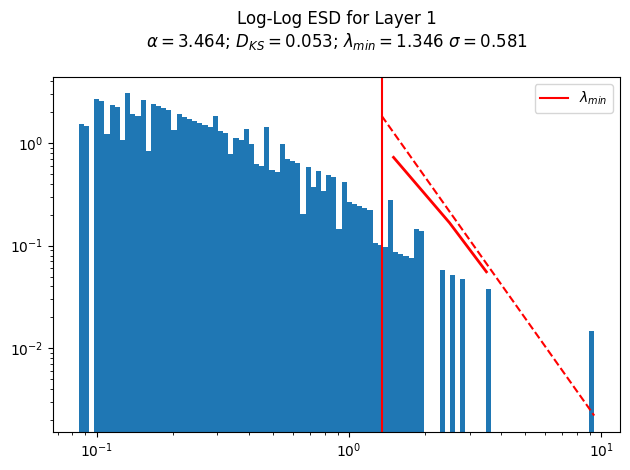

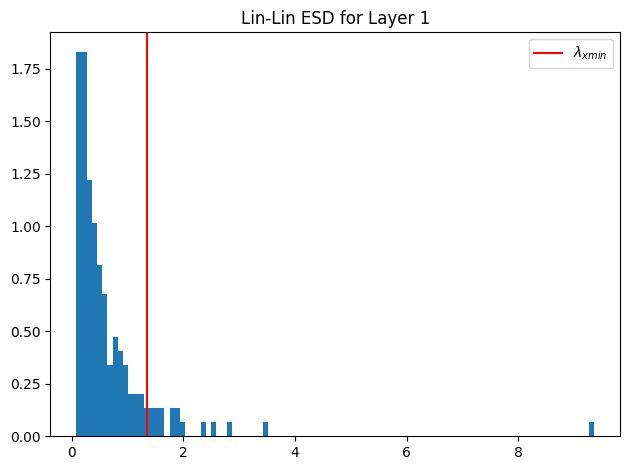

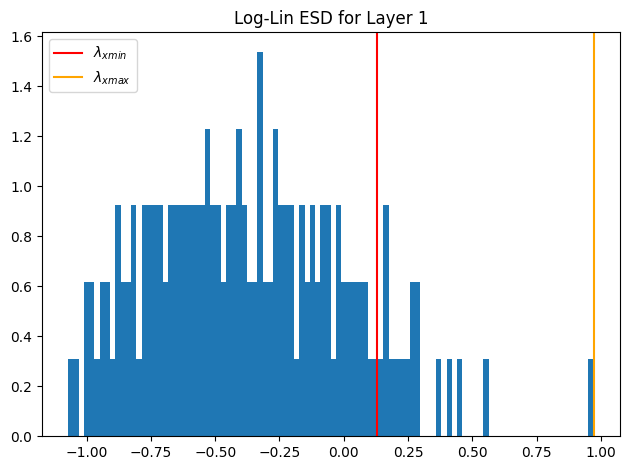

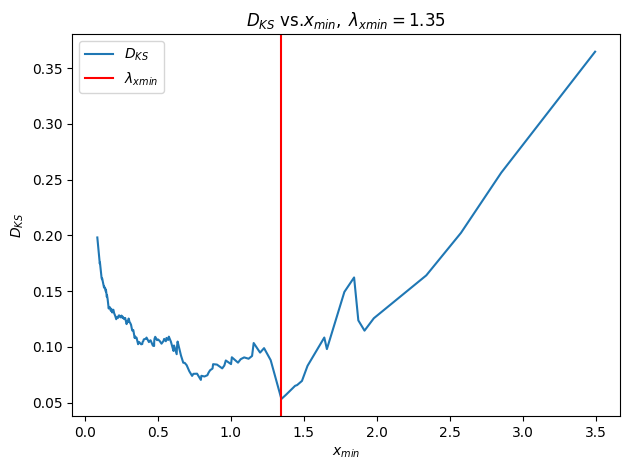

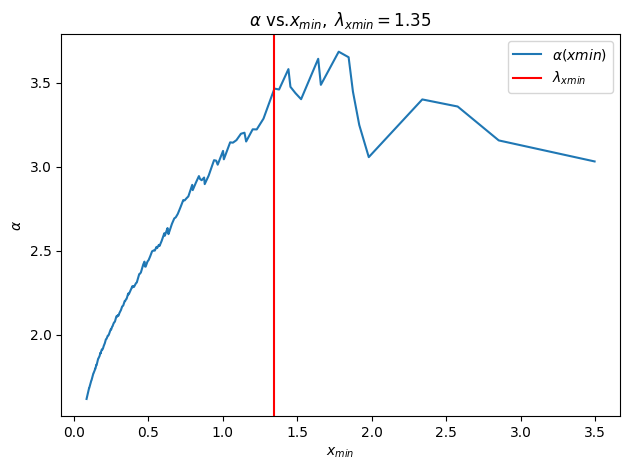

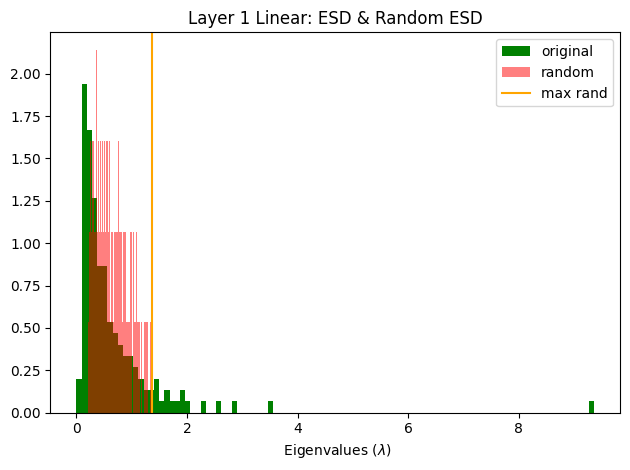

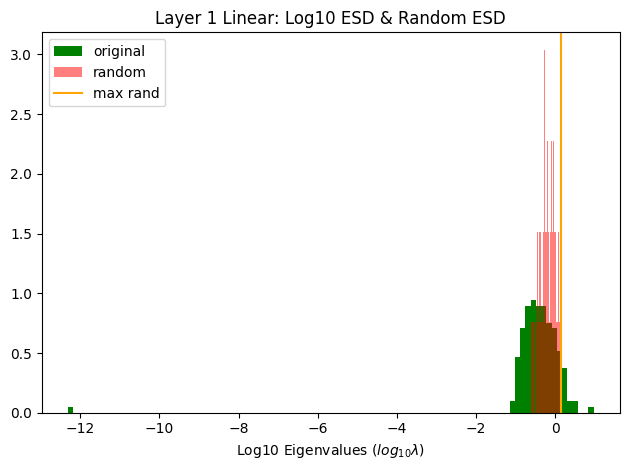

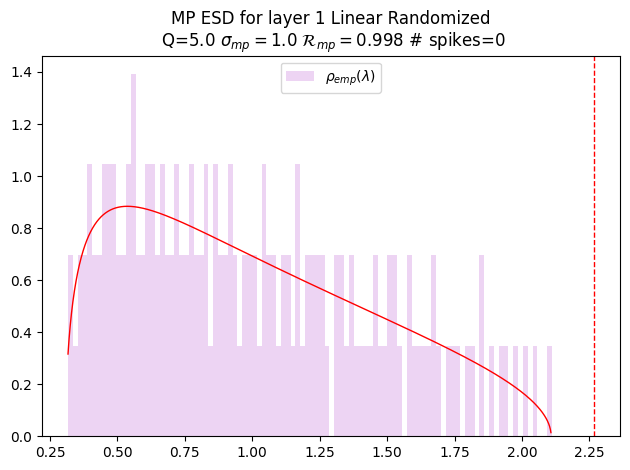

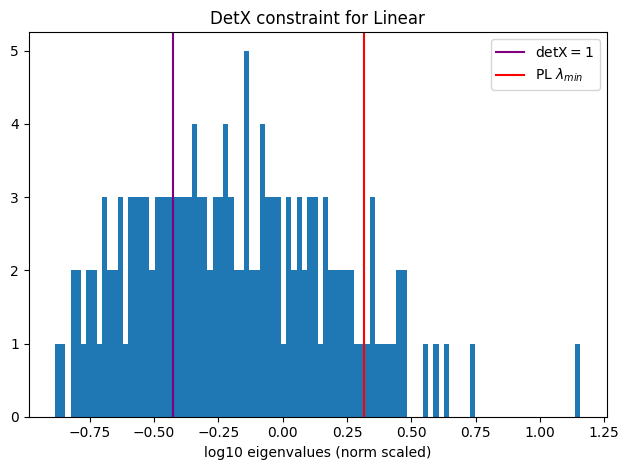


WeightWatcher Diagnostics (W7)
alpha  = 3.464
traps  = 0.0


<Figure size 640x480 with 0 Axes>

In [2]:
# ============================================================
# xgboost2ww Production Example
# Dataset: OpenML credit-g (ID=31)
#
# Goal:
#   - Train a realistic XGBoost model
#   - Avoid trivial overfitting
#   - Compute W7 using xgboost2ww
#   - Run WeightWatcher with detX=True
#   - Show ONLY the WeightWatcher spectral plot
# ============================================================

!pip -q install "pandas==2.2.2" xgboost weightwatcher scikit-learn openml scipy pyarrow
!apt-get -qq update && apt-get -qq install -y git

# Clone + install xgboost2ww
!rm -rf /content/xgboost2ww
!git clone https://github.com/CalculatedContent/xgboost2ww.git /content/xgboost2ww
!pip -q install -e /content/xgboost2ww

# Fix namespace cache
import sys
sys.path.insert(0, "/content/xgboost2ww/src")
sys.modules.pop("xgboost2ww", None)

from xgboost2ww import convert

import numpy as np
import pandas as pd
import xgboost as xgb
import openml

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

import torch
import weightwatcher as ww

RNG = 0
np.random.seed(RNG)

# ------------------------------------------------------------
# Load credit-g dataset (OpenML ID 31)
# ------------------------------------------------------------
ds = openml.datasets.get_dataset(31)
Xdf, y_raw, _, _ = ds.get_data(dataset_format="dataframe",
                               target=ds.default_target_attribute)

y_codes, uniques = pd.factorize(y_raw)
y = y_codes.astype(int)

# ------------------------------------------------------------
# Simple preprocessing: impute + one-hot
# ------------------------------------------------------------
cat_cols = Xdf.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in Xdf.columns if c not in cat_cols]

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ]), cat_cols)
])

X = pre.fit_transform(Xdf)

# ------------------------------------------------------------
# True holdout split (never used in OOF)
# ------------------------------------------------------------
Xtr, Xte, ytr, yte = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RNG,
    stratify=y
)

# ------------------------------------------------------------
# Train a regularized XGBoost model (non-trivial, not overfit)
# ------------------------------------------------------------
params = dict(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,
    gamma=0.1,
    seed=RNG,
)

dtr = xgb.DMatrix(Xtr, label=ytr)
dte = xgb.DMatrix(Xte, label=yte)

bst = xgb.train(
    params=params,
    dtrain=dtr,
    num_boost_round=800,
    evals=[(dtr, "train")],
    early_stopping_rounds=50,
    verbose_eval=False,
)

# ------------------------------------------------------------
# Evaluate model
# ------------------------------------------------------------
m_tr = bst.predict(dtr, output_margin=True)
p_tr = 1.0 / (1.0 + np.exp(-m_tr))
train_acc = accuracy_score(ytr, (p_tr >= 0.5).astype(int))

m_te = bst.predict(dte, output_margin=True)
p_te = 1.0 / (1.0 + np.exp(-m_te))
test_acc = accuracy_score(yte, (p_te >= 0.5).astype(int))

print(f"Train accuracy: {train_acc:.3f}")
print(f"Test  accuracy: {test_acc:.3f}")

# ------------------------------------------------------------
# Compute W7 using xgboost2ww
# (OOF increments, training-only)
# ------------------------------------------------------------
layer_W7 = convert(
    model=bst,
    data=Xtr,
    labels=ytr,
    W="W7",
    nfolds=5,
    t_points=160,
    random_state=RNG,
    train_params=params,
    num_boost_round=bst.best_iteration + 1,
    multiclass="error",
    return_type="torch",
    verbose=False,
)

# ------------------------------------------------------------
# WeightWatcher diagnostics
# ------------------------------------------------------------
watcher = ww.WeightWatcher(model=layer_W7)

details_df = watcher.analyze(
    plot=True,
    randomize=True,
    detX=True
)

alpha = float(details_df["alpha"].iloc[0])
traps = float(details_df["rand_num_spikes"].iloc[0])

print("\nWeightWatcher Diagnostics (W7)")
print(f"alpha  = {alpha:.3f}")
print(f"traps  = {traps:.1f}")